__<h2>Importent Setup and library:</h2>__

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from PIL import Image
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

__<h2>Load the data: the Cats vs Dogs dataset:</h2>__
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
First, let's download the 786M ZIP archive of the raw data:
</p>
</div>

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  89.0M      0  0:00:08  0:00:08 --:--:-- 99.7M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   __notebook__.ipynb	       'readme[1].txt'
 PetImages		   kagglecatsanddogs_5340.zip


__<h2>Filter out corrupted images:</h2>__
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.
</p>
</div>

In [4]:
img_link=list(Path('/kaggle/working/PetImages/').glob(r'**/*.jpg'))
count_num=0
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)
    if not find_img:
        count_num+=1
        os.remove(str(lnk))
print('Total %d pcs image delete from Dataset' % count_num)

Total 1590 pcs image delete from Dataset


__<h2>Generate a Dataset:</h2>__

In [5]:
imgsize=(180,180)
batchsize=32

train_data=tf.keras.preprocessing.image_dataset_from_directory('PetImages',
                                                              validation_split=0.2,
                                                              subset='training',
                                                              seed=1337,
                                                              image_size=imgsize,
                                                              batch_size=batchsize)
val_data=tf.keras.preprocessing.image_dataset_from_directory('PetImages',
                                                              validation_split=0.2,
                                                              subset='validation',
                                                              seed=1337,
                                                              image_size=imgsize,
                                                              batch_size=batchsize)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.


2022-10-21 13:53:23.212422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 13:53:23.213429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 13:53:23.556067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 13:53:23.557039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 13:53:23.557959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


__<h2>Visualize the data (plot image):</h2>__
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
Here are the first 9 images in the training dataset. As you can see, label "dog" and label "cat".
</p>
</div>

2022-10-21 13:53:31.157017: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


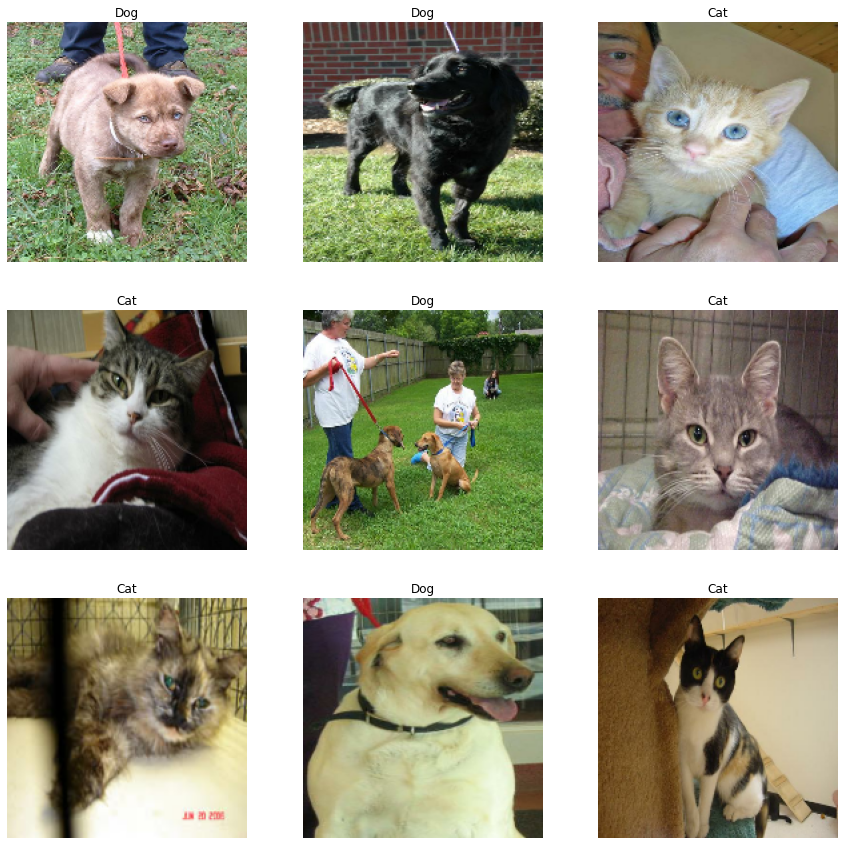

In [6]:
image_name={index:name for index,name in enumerate(train_data.class_names)}
plt.figure(figsize=(15,15))
for nm,lb in train_data.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(nm[i].numpy().astype("uint8"))
        plt.title(image_name[int(lb[i])])
        plt.axis('off')
        
plt.show()

__<h2>Using image data augmentation:</h2>__
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.
</p>
</div>

In [7]:
image_augmentation=tf.keras.Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(0.1),
    ]
)

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


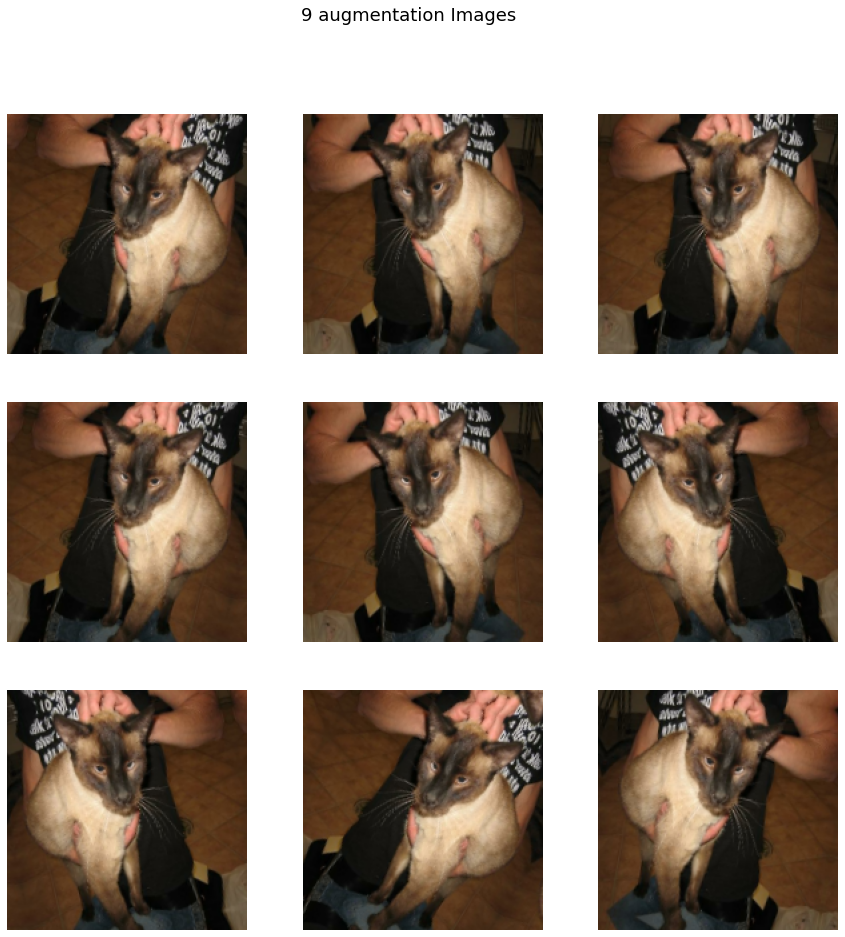

In [8]:
plt.figure(figsize=(15,15))
for img,__ in train_data.take(1):
    for i in range(9):
        imge_ag=image_augmentation(img)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(imge_ag[0].numpy().astype('uint8'))
        plt.axis('off')
        plt.suptitle('9 augmentation Images', fontsize=18)

__<h2>Configure the dataset for performance:</h2>__
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:
</p>
</div>

In [9]:
train_data = train_data.prefetch(buffer_size=32)
val_data = val_data.prefetch(buffer_size=32)

__<h2>Build a model:</h2>__
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:

We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.
</p>
</div>

In [10]:
def make_model(input_shape,final_activation):
    #inputs=keras.Input(shape=input_shape)
    #x=image_augmentation(inputs)
    #x=layers.Rescaling(1.0/255)(x)
    
    for nuron in [32,64]:
        inputs=keras.Input(shape=input_shape)
        x=image_augmentation(inputs)
        x=layers.Rescaling(1.0/255)(x)
        x=layers.Conv2D(nuron,3,strides=2, padding="same", activation='relu')(x)
        x=layers.BatchNormalization()(x)
        
    previous_block_activation = x
        
    for nuron1 in [128, 256, 512, 728]:
        x=layers.SeparableConv2D(nuron1,3,padding="same", activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.MaxPooling2D(3, strides=2, padding="same")(x)
        residual=layers.Conv2D(nuron1, 1, strides=2, padding="same")(previous_block_activation)
        x=layers.add([x,residual])
        previous_block_activation = x 

        
    x=layers.SeparableConv2D(1024, 3, padding="same", activation='relu')(x)
    x=layers.BatchNormalization()(x)
    x=layers.GlobalAveragePooling2D()(x)
    
    if final_activation==1:
        activation='sigmoid'
        units=final_activation
    else:
        activation='softmax'
        units=final_activation
        
    x=layers.Dropout(0.5)(x)
    x=layers.Flatten()(x)
    outputs=layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

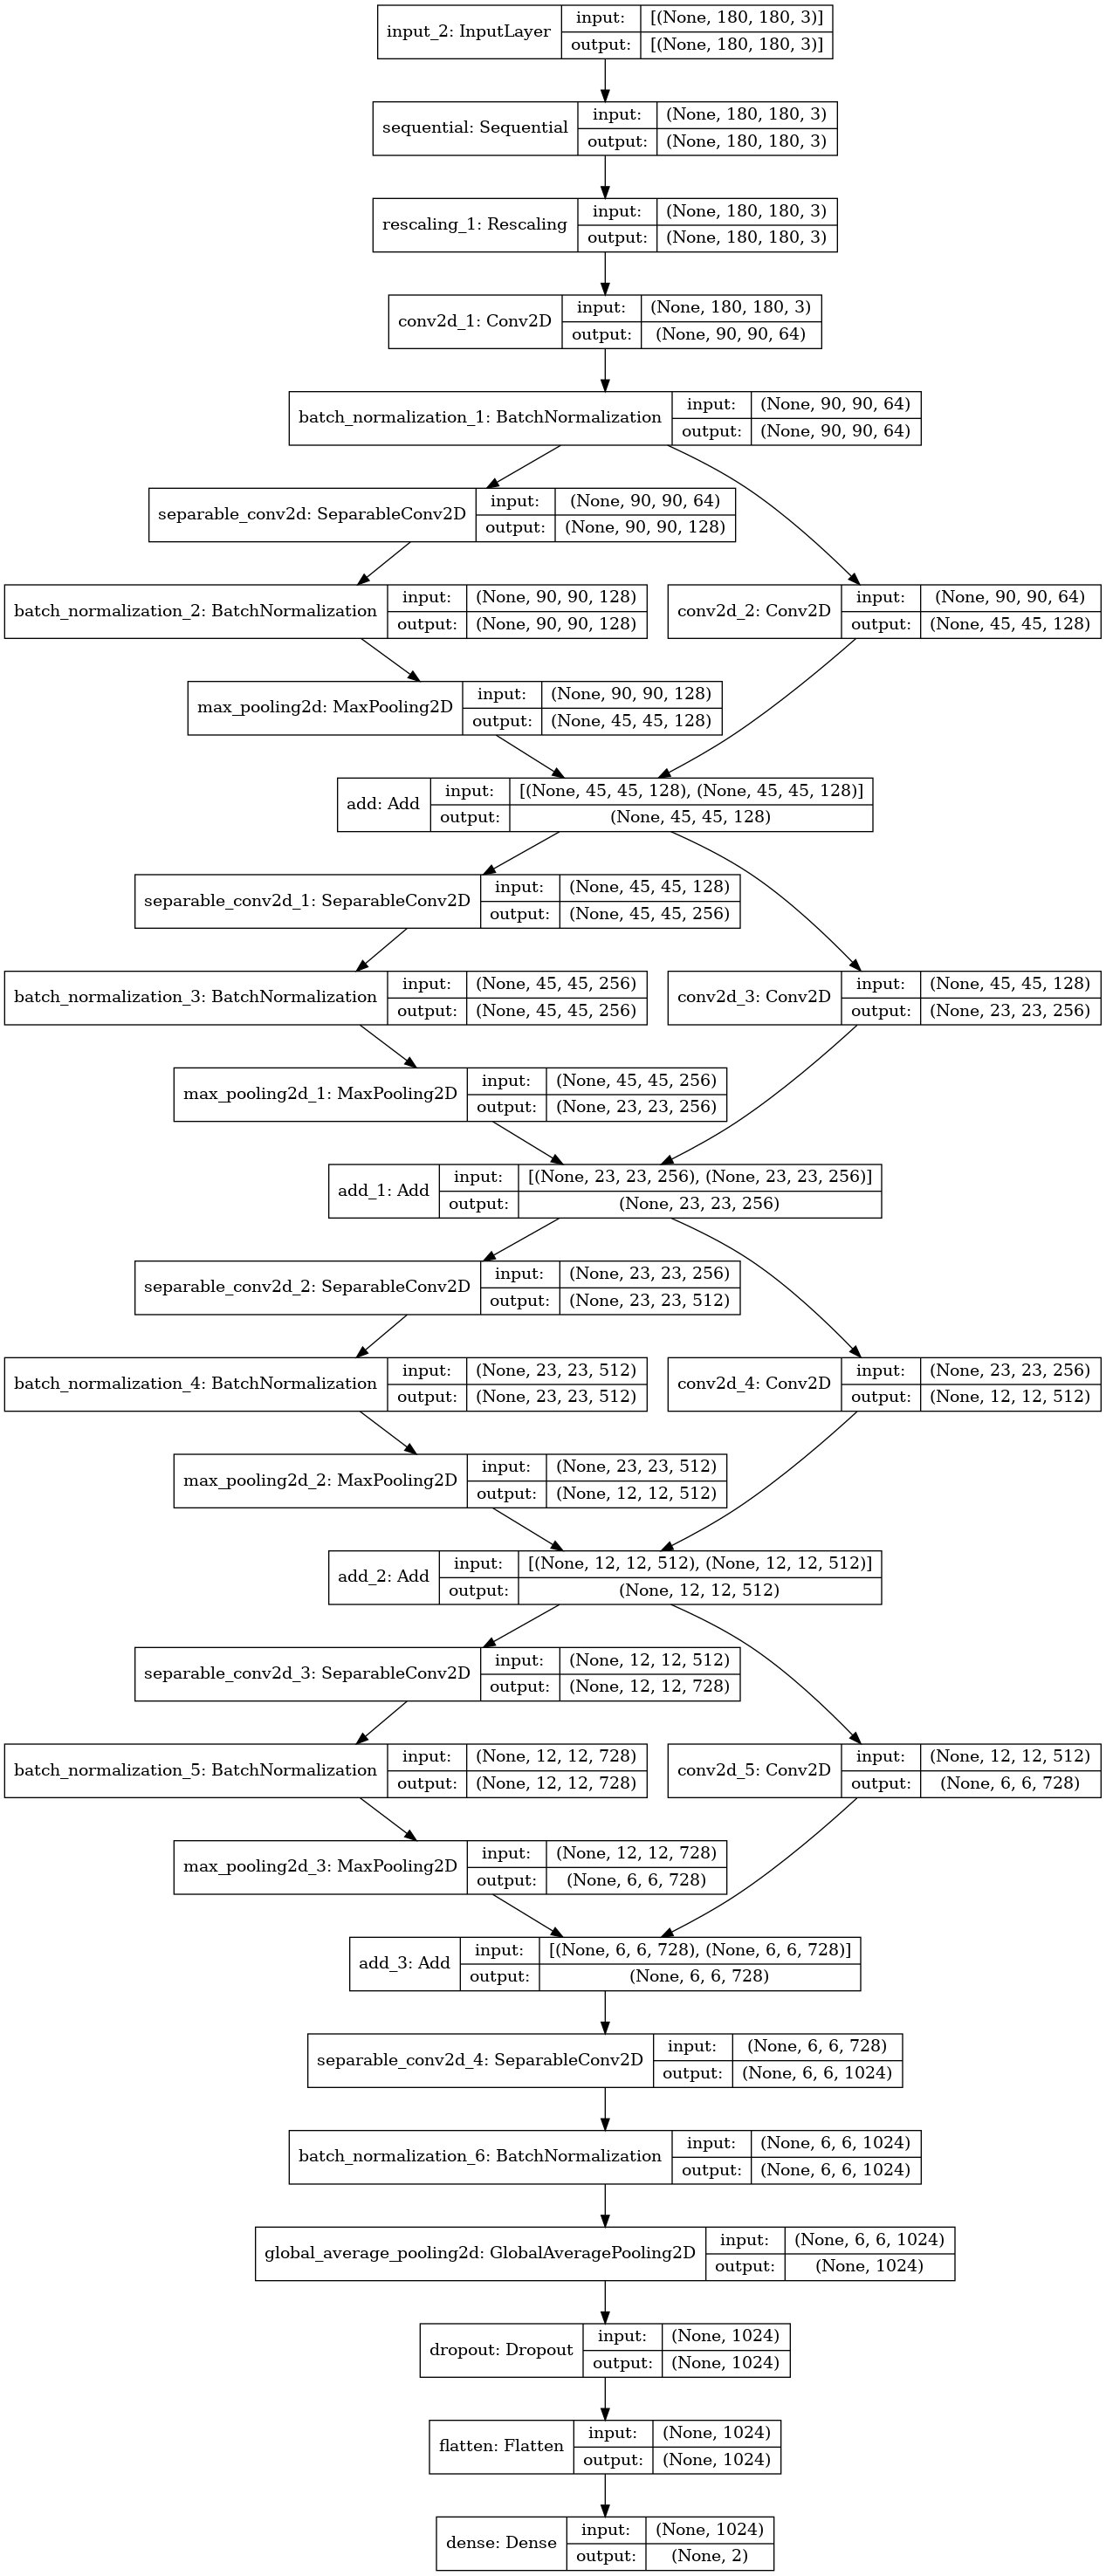

In [11]:
activation=2
model = make_model((180,180,3),activation)
keras.utils.plot_model(model, show_shapes=True)

epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']
)
model.fit(
    train_data, epochs=epochs, callbacks=callbacks, validation_data=val_data,
)

In [12]:
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = "adam", 
              metrics = "accuracy")

tensorboard = TensorBoard(log_dir="logs")

early_stp=EarlyStopping(monitor='val_accuracy',
                        mode='max', 
                        verbose=1, 
                        patience=20)
checkpoint = ModelCheckpoint('model.h5', 
                             monitor='val_accuracy', 
                             mode='Auto',
                             verbose=1,
                             save_best_only=True )

reduce_LR = ReduceLROnPlateau(monitor="val_accuracy", 
                             factor = 0.3, 
                             patience = 2, 
                             min_delta=0.001, 
                             mode = "auto", 
                            verbose = 1)

History = model.fit(train_data,
                              validation_data=val_data,
                              epochs=10,verbose=1,
                              callbacks=[checkpoint,early_stp,tensorboard,reduce_LR])

2022-10-21 13:53:37.575441: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-21 13:53:37.575498: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-21 13:53:37.580056: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-10-21 13:53:38.237470: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-21 13:53:38.237670: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
2022-10-21 13:53:42.965049: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/586 [..............................] - ETA: 2:46:00 - loss: 0.8224 - accuracy: 0.5938

2022-10-21 13:53:55.508569: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-21 13:53:55.508613: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/586 [..............................] - ETA: 9:39 - loss: 1.1216 - accuracy: 0.5938   

2022-10-21 13:53:56.463987: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-21 13:53:56.465281: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-21 13:53:56.628323: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 383 callback api events and 380 activity events. 
2022-10-21 13:53:56.645814: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


  3/586 [..............................] - ETA: 6:49 - loss: 0.8746 - accuracy: 0.6771

2022-10-21 13:53:56.683543: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_10_21_13_53_56

2022-10-21 13:53:56.695675: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_10_21_13_53_56/efd3e629ecfd.trace.json.gz
2022-10-21 13:53:56.739823: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_10_21_13_53_56

2022-10-21 13:53:56.744287: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_10_21_13_53_56/efd3e629ecfd.memory_profile.json.gz
2022-10-21 13:53:56.745433: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/train/plugins/profile/2022_10_21_13_53_56
Dumped tool data for xplane.pb to logs/train/plugins/profile/2022_10_21_13_53_56/efd3e629ecfd.xplane.

294/586 [==============>...............] - ETA: 35s - loss: 0.6558 - accuracy: 0.6623

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 32s - loss: 0.6406 - accuracy: 0.6707

402/586 [===================>..........] - ETA: 22s - loss: 0.6208 - accuracy: 0.6818

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 21s - loss: 0.6187 - accuracy: 0.6826

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 19s - loss: 0.6154 - accuracy: 0.6848

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 19s - loss: 0.6136 - accuracy: 0.6858

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.7057

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 96s 135ms/step - loss: 0.5825 - accuracy: 0.7057 - val_loss: 0.8373 - val_accuracy: 0.5329

Epoch 00001: val_accuracy improved from -inf to 0.53289, saving model to model.h5
Epoch 2/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 36s - loss: 0.4560 - accuracy: 0.7853

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


325/586 [===============>..............] - ETA: 32s - loss: 0.4509 - accuracy: 0.7879

403/586 [===================>..........] - ETA: 23s - loss: 0.4427 - accuracy: 0.7927

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 21s - loss: 0.4422 - accuracy: 0.7927

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 20s - loss: 0.4395 - accuracy: 0.7945

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 19s - loss: 0.4383 - accuracy: 0.7949

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.4234 - accuracy: 0.8043

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 81s 138ms/step - loss: 0.4233 - accuracy: 0.8044 - val_loss: 0.4818 - val_accuracy: 0.7661

Epoch 00002: val_accuracy improved from 0.53289 to 0.76613, saving model to model.h5
Epoch 3/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 37s - loss: 0.3418 - accuracy: 0.8480

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


325/586 [===============>..............] - ETA: 33s - loss: 0.3416 - accuracy: 0.8479

403/586 [===================>..........] - ETA: 23s - loss: 0.3399 - accuracy: 0.8506

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


413/586 [====================>.........] - ETA: 22s - loss: 0.3396 - accuracy: 0.8504

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 20s - loss: 0.3386 - accuracy: 0.8507

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 19s - loss: 0.3386 - accuracy: 0.8504

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.3303 - accuracy: 0.8547

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 81s 138ms/step - loss: 0.3305 - accuracy: 0.8547 - val_loss: 0.2596 - val_accuracy: 0.8891

Epoch 00003: val_accuracy improved from 0.76613 to 0.88915, saving model to model.h5
Epoch 4/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 37s - loss: 0.2800 - accuracy: 0.8780

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


325/586 [===============>..............] - ETA: 33s - loss: 0.2806 - accuracy: 0.8784

403/586 [===================>..........] - ETA: 23s - loss: 0.2779 - accuracy: 0.8800

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 22s - loss: 0.2766 - accuracy: 0.8804

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


425/586 [====================>.........] - ETA: 20s - loss: 0.2773 - accuracy: 0.8801

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 19s - loss: 0.2772 - accuracy: 0.8803

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.2761 - accuracy: 0.8805

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 81s 138ms/step - loss: 0.2763 - accuracy: 0.8804 - val_loss: 0.2356 - val_accuracy: 0.9024

Epoch 00004: val_accuracy improved from 0.88915 to 0.90239, saving model to model.h5
Epoch 5/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 37s - loss: 0.2480 - accuracy: 0.8953

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


325/586 [===============>..............] - ETA: 33s - loss: 0.2461 - accuracy: 0.8956

404/586 [===================>..........] - ETA: 23s - loss: 0.2489 - accuracy: 0.8943

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 22s - loss: 0.2487 - accuracy: 0.8943

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 20s - loss: 0.2481 - accuracy: 0.8946

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


432/586 [=====================>........] - ETA: 19s - loss: 0.2487 - accuracy: 0.8946

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.2458 - accuracy: 0.8954

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 81s 138ms/step - loss: 0.2458 - accuracy: 0.8953 - val_loss: 0.2546 - val_accuracy: 0.8953

Epoch 00005: val_accuracy did not improve from 0.90239
Epoch 6/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


295/586 [==============>...............] - ETA: 37s - loss: 0.2257 - accuracy: 0.9047

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


325/586 [===============>..............] - ETA: 33s - loss: 0.2262 - accuracy: 0.9045

403/586 [===================>..........] - ETA: 23s - loss: 0.2302 - accuracy: 0.9030

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


413/586 [====================>.........] - ETA: 22s - loss: 0.2294 - accuracy: 0.9033

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 20s - loss: 0.2285 - accuracy: 0.9039

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


432/586 [=====================>........] - ETA: 19s - loss: 0.2273 - accuracy: 0.9043

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.2282 - accuracy: 0.9041

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 81s 138ms/step - loss: 0.2283 - accuracy: 0.9040 - val_loss: 0.3294 - val_accuracy: 0.8597

Epoch 00006: val_accuracy did not improve from 0.90239

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 37s - loss: 0.1836 - accuracy: 0.9244

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


325/586 [===============>..............] - ETA: 33s - loss: 0.1803 - accuracy: 0.9254

403/586 [===================>..........] - ETA: 23s - loss: 0.1790 - accuracy: 0.9251

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 22s - loss: 0.1786 - accuracy: 0.9255

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 20s - loss: 0.1785 - accuracy: 0.9255

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 19s - loss: 0.1785 - accuracy: 0.9252

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1731 - accuracy: 0.9286

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 82s 139ms/step - loss: 0.1730 - accuracy: 0.9286 - val_loss: 0.1905 - val_accuracy: 0.9197

Epoch 00007: val_accuracy improved from 0.90239 to 0.91969, saving model to model.h5
Epoch 8/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 37s - loss: 0.1522 - accuracy: 0.9372

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


325/586 [===============>..............] - ETA: 33s - loss: 0.1532 - accuracy: 0.9367

403/586 [===================>..........] - ETA: 23s - loss: 0.1528 - accuracy: 0.9370

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 22s - loss: 0.1526 - accuracy: 0.9374

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 20s - loss: 0.1523 - accuracy: 0.9375

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 19s - loss: 0.1526 - accuracy: 0.9374

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1527 - accuracy: 0.9384

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 81s 137ms/step - loss: 0.1527 - accuracy: 0.9383 - val_loss: 0.2634 - val_accuracy: 0.8988

Epoch 00008: val_accuracy did not improve from 0.91969
Epoch 9/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 37s - loss: 0.1509 - accuracy: 0.9397

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


325/586 [===============>..............] - ETA: 33s - loss: 0.1518 - accuracy: 0.9388

403/586 [===================>..........] - ETA: 23s - loss: 0.1497 - accuracy: 0.9388

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


413/586 [====================>.........] - ETA: 22s - loss: 0.1501 - accuracy: 0.9389

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 20s - loss: 0.1490 - accuracy: 0.9393

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 19s - loss: 0.1490 - accuracy: 0.9392

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1465 - accuracy: 0.9400

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 81s 138ms/step - loss: 0.1465 - accuracy: 0.9399 - val_loss: 0.2202 - val_accuracy: 0.9126

Epoch 00009: val_accuracy did not improve from 0.91969

Epoch 00009: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 10/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 37s - loss: 0.1336 - accuracy: 0.9501

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 33s - loss: 0.1350 - accuracy: 0.9496

402/586 [===================>..........] - ETA: 23s - loss: 0.1345 - accuracy: 0.9482

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 22s - loss: 0.1345 - accuracy: 0.9478

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 20s - loss: 0.1337 - accuracy: 0.9478

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 20s - loss: 0.1330 - accuracy: 0.9483

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9493

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 81s 138ms/step - loss: 0.1301 - accuracy: 0.9493 - val_loss: 0.1386 - val_accuracy: 0.9436

Epoch 00010: val_accuracy improved from 0.91969 to 0.94361, saving model to model.h5


In [13]:
model.evaluate(val_data)

  5/147 [>.............................] - ETA: 5s - loss: 0.1745 - accuracy: 0.9312

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 11/147 [=>............................] - ETA: 5s - loss: 0.1356 - accuracy: 0.9403

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 45/147 [========>.....................] - ETA: 5s - loss: 0.1260 - accuracy: 0.9493

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 61/147 [===========>..................] - ETA: 4s - loss: 0.1296 - accuracy: 0.9477

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


101/147 [===================>..........] - ETA: 2s - loss: 0.1304 - accuracy: 0.9474

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


109/147 [=====================>........] - ETA: 1s - loss: 0.1352 - accuracy: 0.9461

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 7s 45ms/step - loss: 0.1386 - accuracy: 0.9436


[0.13862915337085724, 0.9436138272285461]

__<h2>Reports plot:</h2>__
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
ConfusionMatrix,classification
</p>
</div>

In [14]:
y_lbl=[]
t_lbl=[]
for img,lbl in val_data:
    y_lbl.append(lbl)
    y_pred = model.predict(img)
    if activation==1:
        y_pred = ((y_pred > 0.5)+0).ravel()
        t_lbl.append(y_pred)
    elif activation>1:
        y_pred = np.argmax(y_pred, axis=1)
        t_lbl.append(y_pred)

correct_labels = tf.concat([item for item in y_lbl], axis = 0)
True_labels = tf.concat([item for item in t_lbl], axis = 0)

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


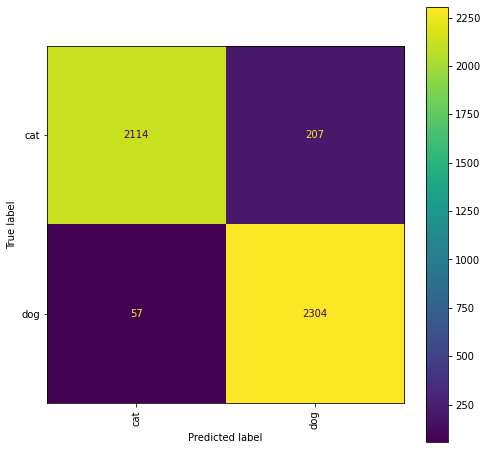

In [15]:
cm = confusion_matrix(correct_labels,True_labels)
cmp = ConfusionMatrixDisplay(cm,display_labels = ['cat', 'dog'])
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation=90)

In [16]:
print(classification_report(correct_labels,True_labels,target_names=['cat', 'dog']))

              precision    recall  f1-score   support

         cat       0.97      0.91      0.94      2321
         dog       0.92      0.98      0.95      2361

    accuracy                           0.94      4682
   macro avg       0.95      0.94      0.94      4682
weighted avg       0.95      0.94      0.94      4682



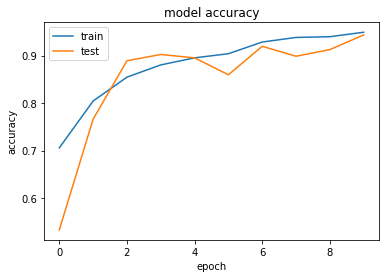

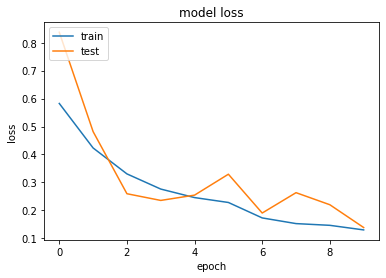

In [17]:
# summarize history for accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()